In [ ]:
# Update the package list to ensure you have the latest information
!apt-get update

# Install OpenJDK 8 (Java Development Kit) headless version silently
# Headless means it doesn't have a GUI, which is suitable for servers or cloud environments
!apt-get install openjdk-8-jdk-headless -qq

# Download Apache Spark version 3.1.2 with Hadoop version 3.2
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz

# Extract the downloaded Spark archive
!tar xf spark-3.1.2-bin-hadoop3.2.tgz

# Install the findspark library using pip
!pip install findspark

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy/main Sources [2,263 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,617 kB]
Get:13 https://ppa.launchpadcontent.net/c2d4

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=7fdb7100a629a2b49b6d2a7c2ee52f94ce51b7428924bd11dd58ffd32b09316e
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
# Mount Google Drive to access files and directories in your Google Drive storage
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


read_dataset
select_columns
convert_to_numeric
feature_engineering
+--------------------+----------+----------------+---------------------+-------------------------+---------------+------------+------------+-----------------------+--------------+------------------+--------------------+
|num_of_prev_attempts|disability|Assessment_count|Submitted_Assessments|Not_submitted_Assessments|Total_resources|Total_clicks|gender_index|highest_education_index|age_band_index|final_result_index|            features|
+--------------------+----------+----------------+---------------------+-------------------------+---------------+------------+------------+-----------------------+--------------+------------------+--------------------+
|                 0.0|       0.0|             6.0|                  0.0|                      6.0|          462.0|         0.0|         0.0|                    2.0|           2.0|               1.0|(11,[2,4,5,8,9,10...|
|                 0.0|       0.0|             5.0|   

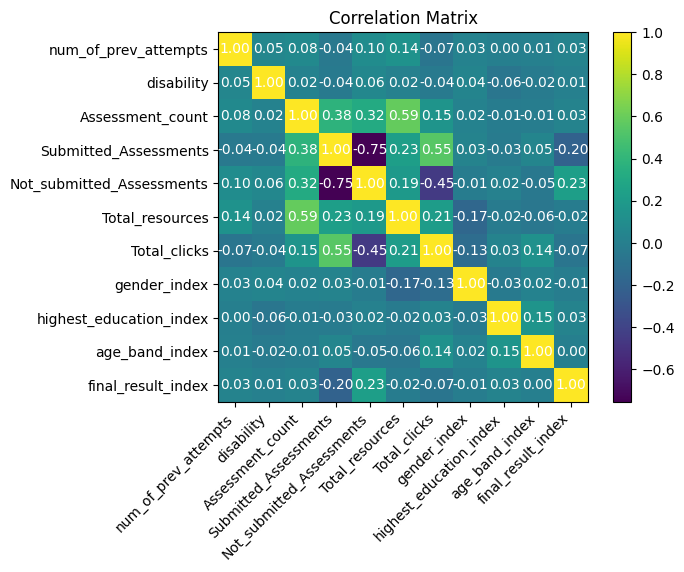

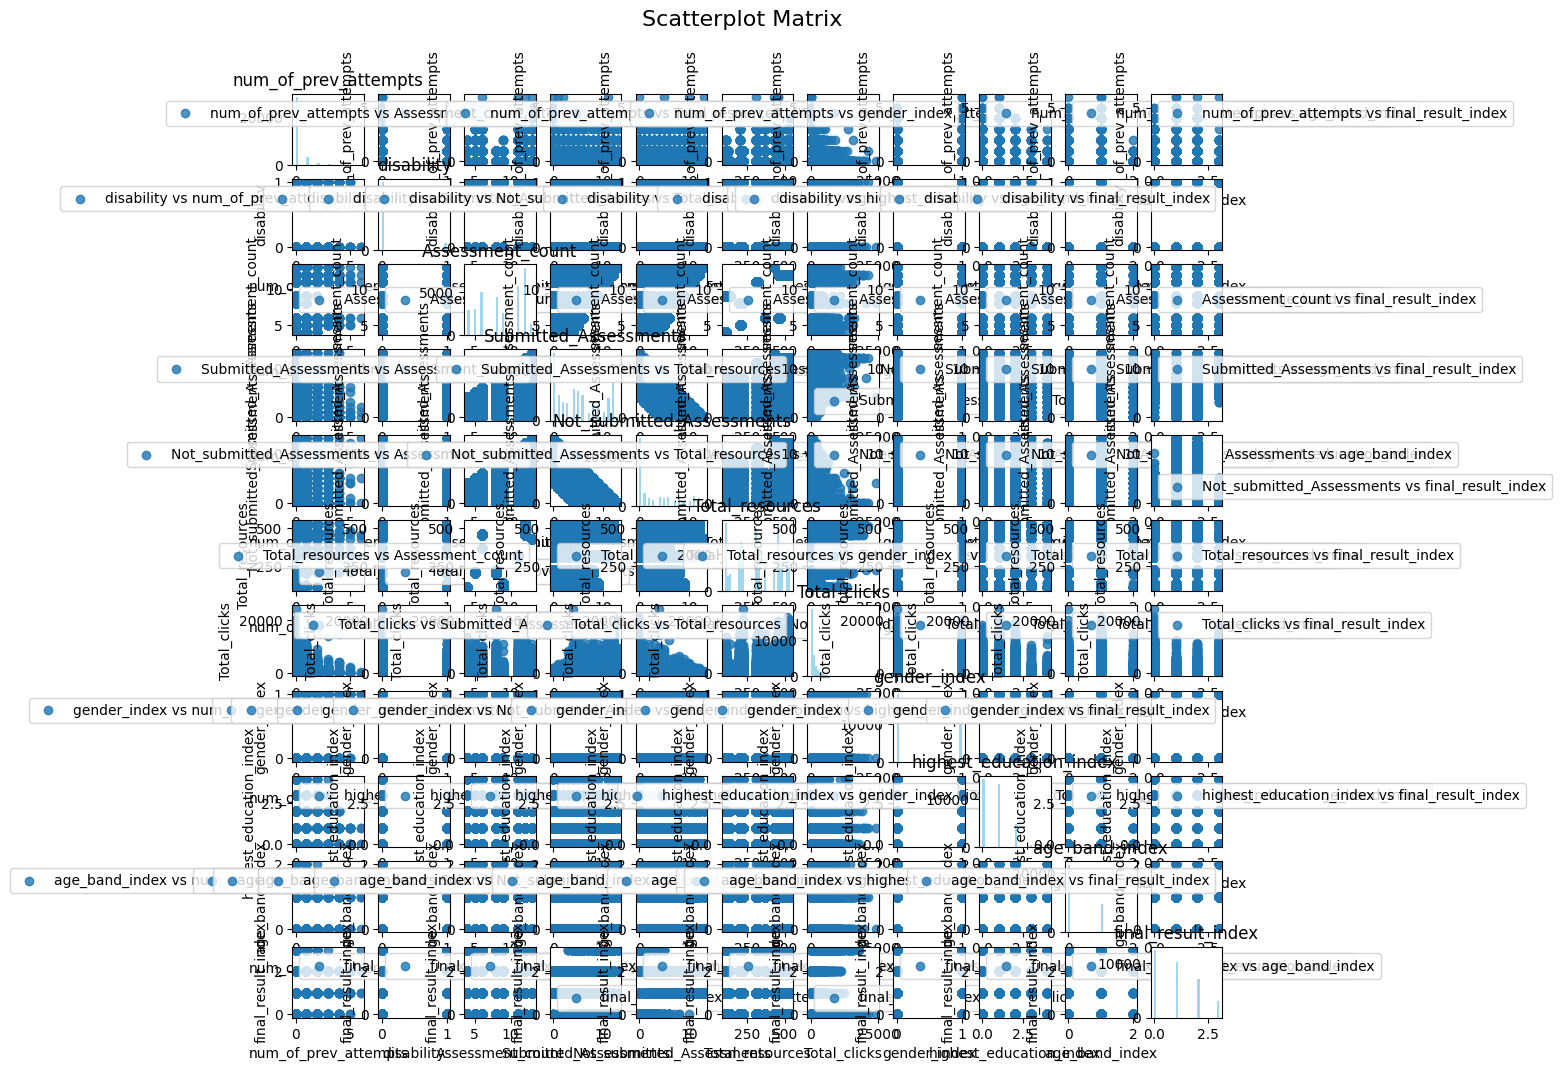

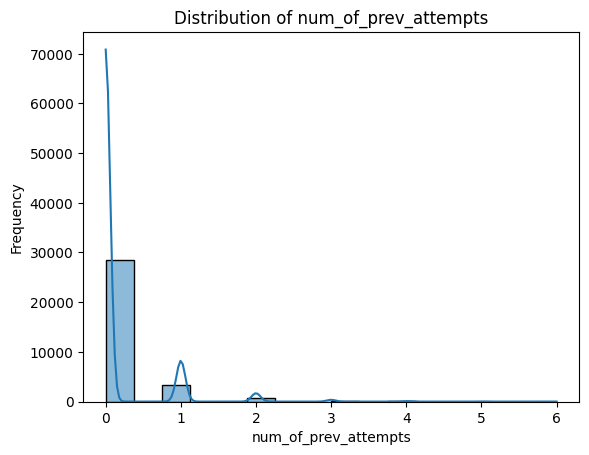

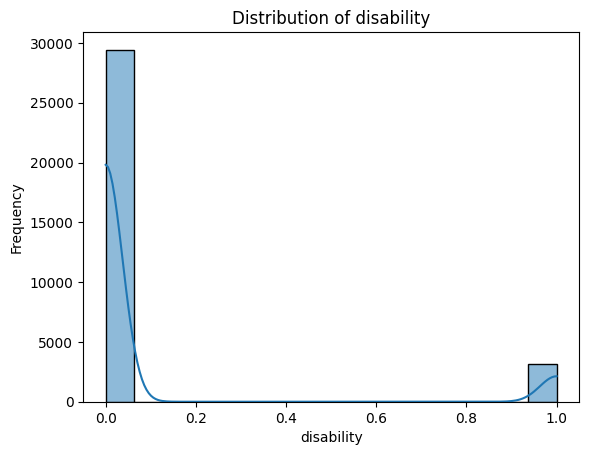

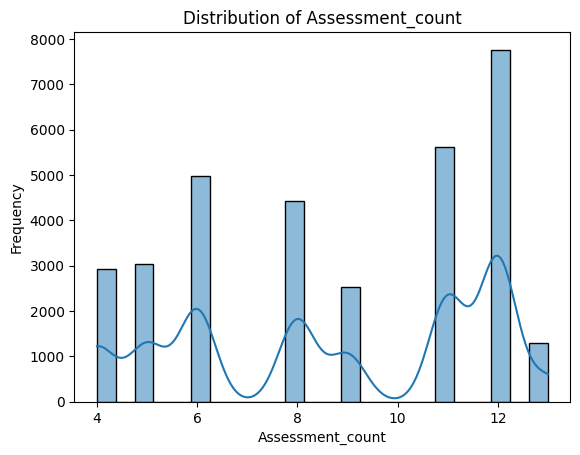

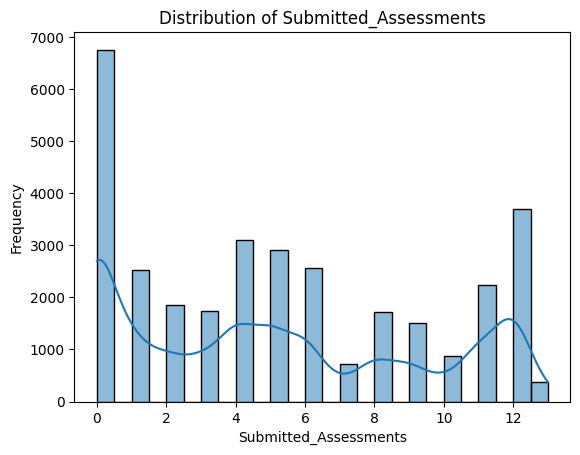

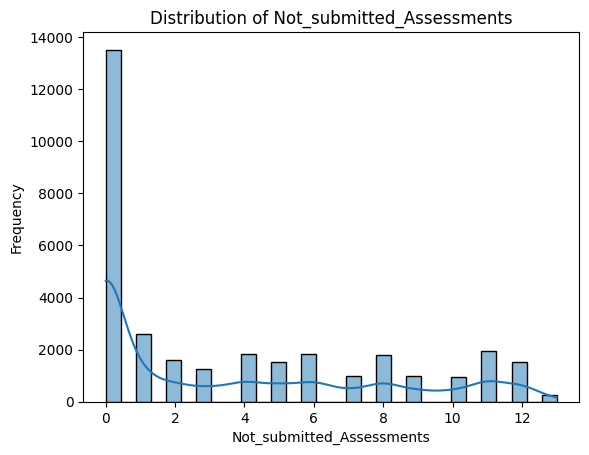

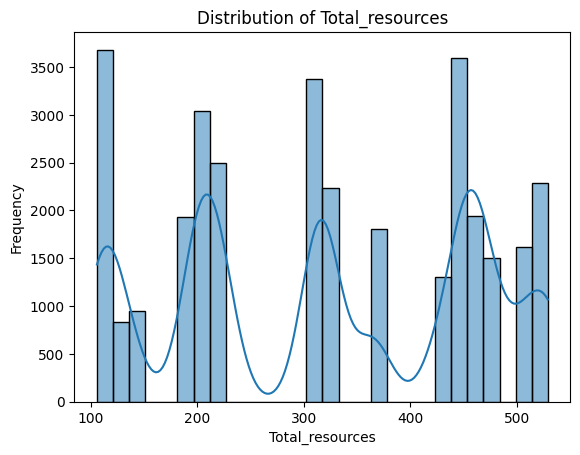

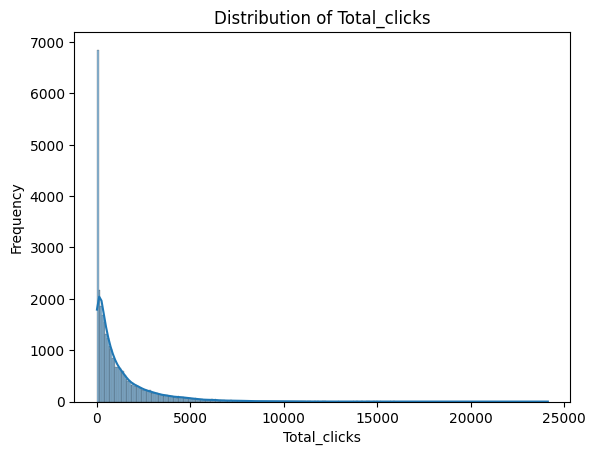

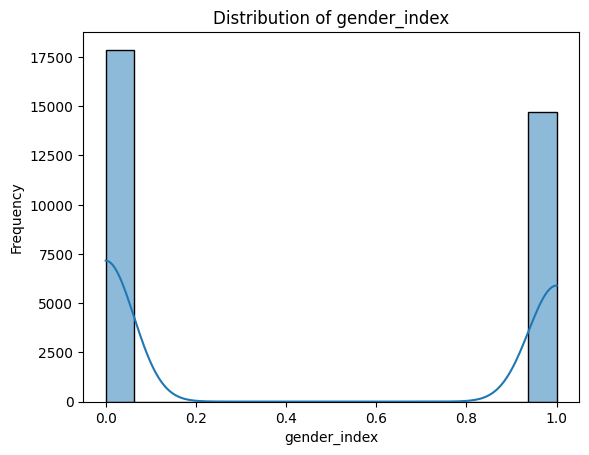

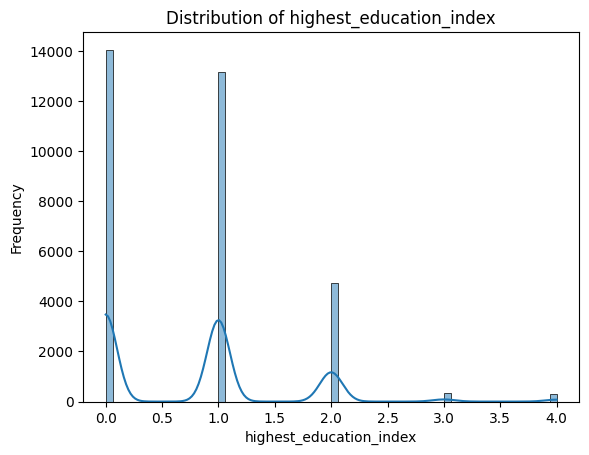

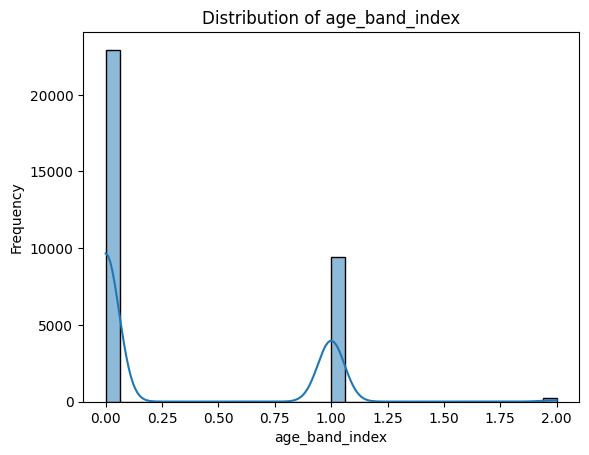

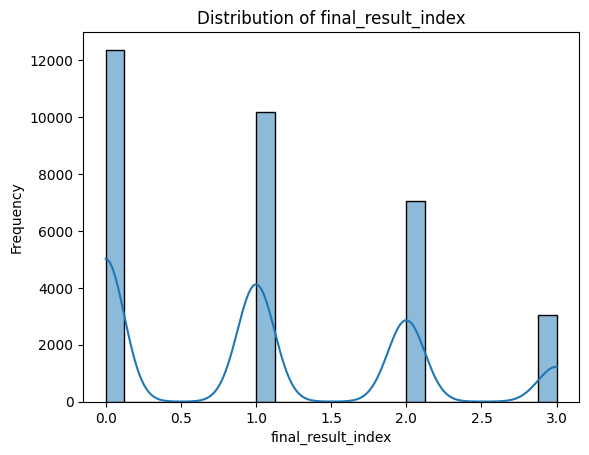

In [ ]:

from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, MultilayerPerceptronClassifier, LogisticRegression, NaiveBayes, LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.sql.functions import isnull, when, count, col,size, split
from pyspark.sql.types import DoubleType, StringType,IntegerType , StringType
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, jaccard_score
from pyspark.ml import Pipeline

from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


class StudentDataClassifier:
    def __init__(self, spark_master="local", app_name="Student Data"):
        # Create a Spark Session
        self.spark = SparkSession.builder \
            .master(spark_master) \
            .appName(app_name) \
            .getOrCreate()

    def read_dataset(self, file_path):
        # Read dataset
        df = (self.spark.read
              .format("csv")
              .option("header", "true")
              .load(file_path))

        return df

    def select_columns(self, df):

        # Filter out rows where final_result is 'Withdrawn'
        df1 = df.filter(col('final_result') != 'Withdrawn')

        # Select specific columns and cast to the appropriate data type
        dataset = df.select(
            # col('code_module'),
            # col('code_presentation'),
            # col('id_student').cast('int'),
            col('gender'),
            col('highest_education'),
            # col('region'),
            # col('imd_band'),
            col('age_band'),
            col('num_of_prev_attempts').cast('int'),
            # col('studied_credits').cast('int'),
            col('disability').cast('int'),
            # col('date_registration').cast('int'),
            # col('date_unregistration').cast('int'),
            col('Assessment_count').cast('int'),
            # col('TMA_count').cast('int'),
            # col('CMA_count').cast('int'),
            # col('Exam_count').cast('int'),
            # col('TMA_Total_score').cast('int'),
            # col('CMA_Total_score').cast('int'),
            # col('Exam_score').cast('int'),
            # col('total_assessment_score').cast('int'),
            col('Submitted_Assessments').cast('int'),
            col('Not_submitted_Assessments').cast('int'),
            # col('Total_Assessments_score_100').cast('int'),
            # col('Average_Assessment_score').cast('double'),
            # col('Total_Mark').cast('double'),
            col('Total_resources').cast('int'),
            col('Total_clicks').cast('int'),
            col('final_result')
        )

        return dataset

    def handle_missing_values(self, dataset):
        # Impute missing values with mean for numerical columns
        numerical_cols = dataset.columns
        for column_name in numerical_cols:
            mean_val = dataset.agg({column_name: 'mean'}).collect()[0][0]
            dataset = dataset.withColumn(column_name, when(col(column_name).isNotNull(), col(column_name)).otherwise(mean_val))

        # # Impute missing values with the most frequent value for categorical columns
        # categorical_cols = ['gender', 'highest_education', 'region', 'imd_band', 'age_band', 'final_result']
        # for column_name in categorical_cols:
        #     mode_val = dataset.groupBy(column_name).count().sort(col("count").desc()).first()[column_name]
        #     dataset = dataset.withColumn(column_name, when(col(column_name).isNotNull(), col(column_name)).otherwise(mode_val))

        return dataset

    def convert_categorical_to_numeric(self, dataset):
        # Convert specific categorical variables to numeric using StringIndexer
        categorical_cols = ['gender', 'highest_education', 'region', 'imd_band', 'age_band', 'final_result']
        index_columns = []
        for column_name in categorical_cols:
            if column_name not in dataset.columns:
                continue
            indexer = StringIndexer(inputCol=column_name, outputCol=f'{column_name}_index', handleInvalid='keep')
            dataset = indexer.fit(dataset).transform(dataset)
            index_columns.append(f'{column_name}_index')

        # Drop the original categorical columns
        dataset = dataset.drop(*categorical_cols)

        return dataset

    def convert_to_numeric(self,df, numeric_cols):
        for col in numeric_cols:
            df = df.withColumn(col, df[col].cast(IntegerType()))
            df = df.na.fill(0)
        return df

    def feature_engineering(self, dataset):
        # Assemble features with VectorAssembler
        required_features = [col_name for col_name in dataset.columns if col_name != 'final_result']
        assembler = VectorAssembler(inputCols=required_features, outputCol='features')
        transformed_data = assembler.transform(dataset)
        return transformed_data

    def compute_correlation_matrix(self, df_assembled):
        correlation_matrix = Correlation.corr(df_assembled, "features").head()
        return correlation_matrix[0].toArray()

    def visualize_correlation_matrix(self, corr_matrix_array, numeric_cols):
        fig, ax = plt.subplots()
        im = ax.imshow(corr_matrix_array, cmap='viridis', interpolation='nearest')

        # Display colorbar
        cbar = plt.colorbar(im)

        # Set tick labels and position
        ax.set_xticks(np.arange(len(numeric_cols)))
        ax.set_yticks(np.arange(len(numeric_cols)))
        ax.set_xticklabels(numeric_cols, rotation=45, ha="right")
        ax.set_yticklabels(numeric_cols)

        # Display the correlation values in each cell
        for i in range(len(numeric_cols)):
            for j in range(len(numeric_cols)):
                text = ax.text(j, i, f'{corr_matrix_array[i, j]:.2f}', ha='center', va='center', color='w')

        # Set title
        plt.title("Correlation Matrix")

        # Display the graph
        plt.show()

    ######################################
    # 3. Create a scatterplot using the Matplotlib plotting library to visually represent two dimensions or features from the chosen dataset.
    #    Distinguish between the various penguin species and genders within the same plot.
    ######################################
    def scatterplot(self,df, x_feature, y_feature):
        pandas_df = df.select([x_feature, y_feature ]).toPandas()
        sns.scatterplot(data=pandas_df, x=x_feature, y=y_feature )
        plt.title(f'Scatterplot of {x_feature} vs {y_feature}  ')
        plt.xlabel(x_feature)
        plt.ylabel(y_feature)
        plt.legend(title='Species')
        plt.show()


    def scatterplot_matrix(self, df, selected_columns):
        pandas_df = df.select([col(column).alias(column) for column in selected_columns]).toPandas()

        num_columns = len(selected_columns)
        fig, axes = plt.subplots(nrows=num_columns, ncols=num_columns, figsize=(12, 12))
        fig.suptitle("Scatterplot Matrix", y=0.95, fontsize=16)

        for i, column1 in enumerate(selected_columns):
            for j, column2 in enumerate(selected_columns):
                ax = axes[i, j]

                if i == j:
                    ax.hist(pandas_df[column1], bins=30, color='skyblue', alpha=0.8)
                    ax.set_title(column1)
                else:
                    ax.scatter(pandas_df[column2], pandas_df[column1], alpha=0.8, label=f"{column1} vs {column2}")
                    ax.set_xlabel(column2)
                    ax.set_ylabel(column1)
                    ax.legend()

        plt.show()

    def visualize_distribution(self, df, numeric_cols):
      for col_name in numeric_cols:
          # Convert Spark DataFrame to Pandas for visualization
          pandas_df = df.select(col_name).toPandas()

          # Plot distribution using seaborn
          sns.histplot(pandas_df[col_name], kde=True)
          plt.title(f'Distribution of {col_name}')
          plt.xlabel(col_name)
          plt.ylabel('Frequency')
          plt.show()

    def visualize_distribution_col(self, df, col_name):
        # Convert Spark DataFrame to Pandas for visualization
        pandas_df = df.select(col_name).toPandas()

        # Plot distribution using seaborn
        sns.histplot(pandas_df[col_name], kde=True)
        plt.title(f'Distribution of {col_name}')
        plt.xlabel(col_name)
        plt.ylabel('Frequency')
        plt.show()


if __name__ == "__main__":
    # Create an instance of StudentDataClassifier
    student_data_classifier = StudentDataClassifier()

    # Set the path to the Student Data dataset
    dataset_path = "/content/drive/My Drive/MalmoMsc/CapstoneProject/DataSet/train.v3.csv"  # Replace with the actual path

    # Read and preprocess the dataset
    df = student_data_classifier.read_dataset(dataset_path)
    print('read_dataset')
    # df.show()

    dataset = student_data_classifier.select_columns(df)
    print('select_columns')
    # dataset.show()

    columns = ['Total_resources','Total_clicks'] # 'Total_Mark', 'total_assessment_score','Total_Assessments_score_100','Average_Assessment_score',
    dataset = student_data_classifier.convert_to_numeric(dataset,columns)
    print('convert_to_numeric')
    # dataset.show()

    dataset = student_data_classifier.handle_missing_values(dataset)
    # dataset.show()
    dataset = student_data_classifier.convert_categorical_to_numeric(dataset)
    # dataset.show()

    transformed_data = student_data_classifier.feature_engineering(dataset)
    print('feature_engineering')
    transformed_data.show()

    numeric_cols = ["num_of_prev_attempts", "disability", "Assessment_count", "Submitted_Assessments", "Not_submitted_Assessments", "Total_resources", "Total_clicks", "gender_index", "highest_education_index", "age_band_index", "final_result_index"]
     #[ 'Total_resources','Total_clicks','final_result_index'] #'date_registration','studied_credits','disability', 'total_assessment_score','Total_Assessments_score_100','Average_Assessment_score',

    corr_matrix_array = student_data_classifier.compute_correlation_matrix(transformed_data)
    student_data_classifier.visualize_correlation_matrix(corr_matrix_array, numeric_cols)


    # x_feature_scatter = 'Total_Mark'
    # y_feature_scatter = 'Total_clicks'
    # student_data_classifier.scatterplot(dataset,x_feature_scatter, y_feature_scatter)

    selected_columns_scatter_matrix =numeric_cols
    student_data_classifier.scatterplot_matrix(dataset,numeric_cols)


    # Visualize distribution for each column
    student_data_classifier.visualize_distribution(dataset, numeric_cols)


